In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style='whitegrid')
%matplotlib inline


In [ ]:
# Download AAPL data from Yahoo Finance
data = yf.download("AAPL", start="2015-01-01", end="2025-01-01")

# Keep only the 'Close' column
data = data[['Close']]

# Show first few rows
data.head()


/tmp/ipython-input-2161372992.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.261047
2015-01-05,23.577574
2015-01-06,23.579794
2015-01-07,23.910435
2015-01-08,24.829130


In [ ]:
# Data shape and info
print("Shape:", data.shape)
print(data.info())

# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Quick descriptive statistics
print(data.describe())


Shape: (2516, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, AAPL)  2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB
None
Missing values:
 Price  Ticker
Close  AAPL      0
dtype: int64
Price         Close
Ticker         AAPL
count   2516.000000
mean      93.949921
std       65.504728
min       20.624048
25%       35.257092
50%       64.450443
75%      150.379646
max      258.103729


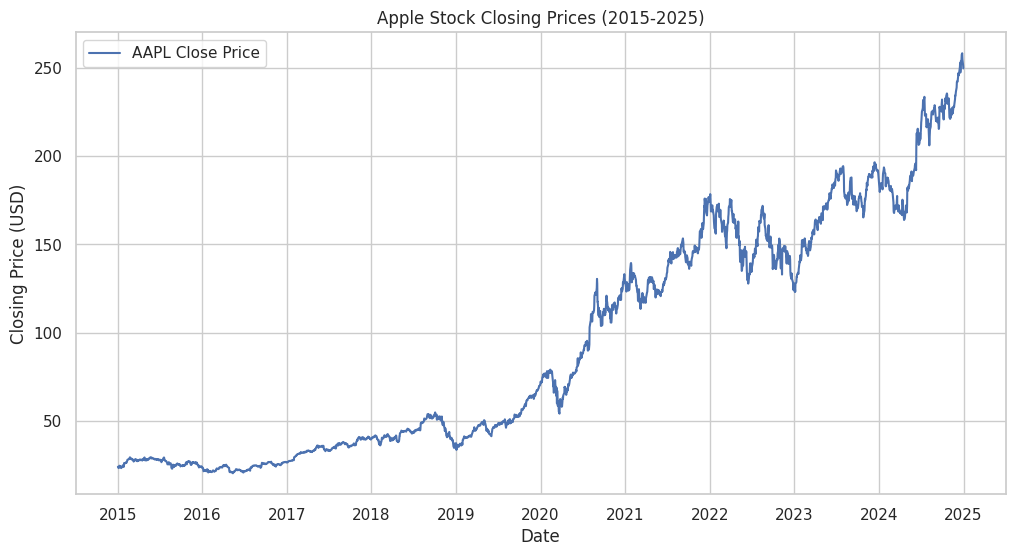

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='AAPL Close Price')
plt.title("Apple Stock Closing Prices (2015-2025)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.show()


In [ ]:
# Flatten column names if needed
data.columns = ['Close']
data.head()


,Close
Date,
2015-01-02,24.261047
2015-01-05,23.577574
2015-01-06,23.579794
2015-01-07,23.910435
2015-01-08,24.829130


In [ ]:
# Reindex to daily frequency
data = data.asfreq('D')

# Fill missing values (non-trading days like weekends/holidays)
data['Close'] = data['Close'].ffill()

# Check again
print("After reindexing:", data.shape)
print("Missing values:", data.isnull().sum().values[0])


After reindexing: (3652, 1)
Missing values: 0


In [ ]:
from scipy import stats

# Calculate Z-scores
z_scores = np.abs(stats.zscore(data['Close']))
outliers = data[z_scores > 3]

print("Number of outliers detected:", len(outliers))
print(outliers.head())


Number of outliers detected: 0
Empty DataFrame
Columns: [Close]
Index: []


In [ ]:
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month
data['year'] = data.index.year
data['quarter'] = data.index.quarter
data.head()


,Close,day_of_week,month,year,quarter
Date,,,,,
2015-01-02,24.261047,4,1,2015,1
2015-01-03,24.261047,5,1,2015,1
2015-01-04,24.261047,6,1,2015,1
2015-01-05,23.577574,0,1,2015,1
2015-01-06,23.579794,1,1,2015,1


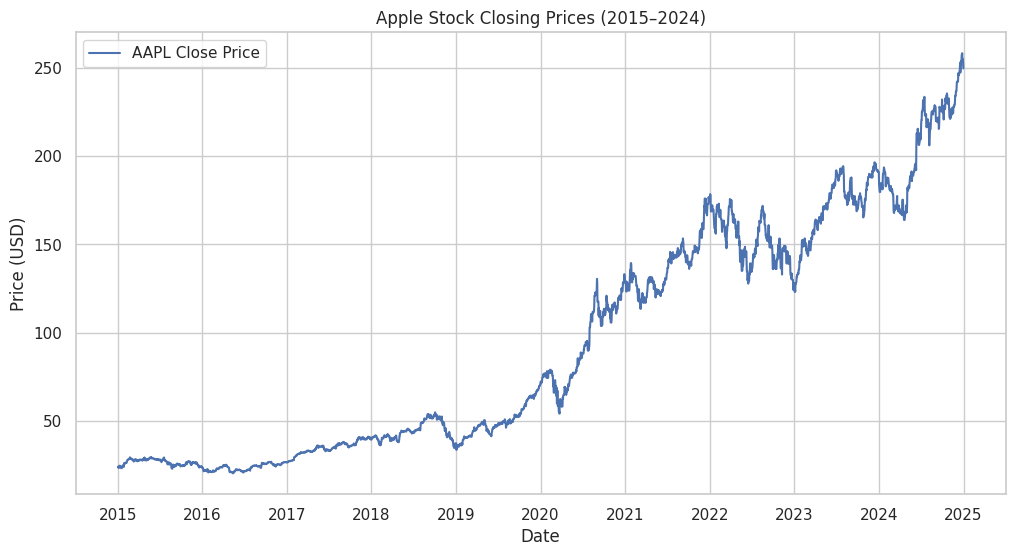

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='AAPL Close Price')
plt.title("Apple Stock Closing Prices (2015–2024)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


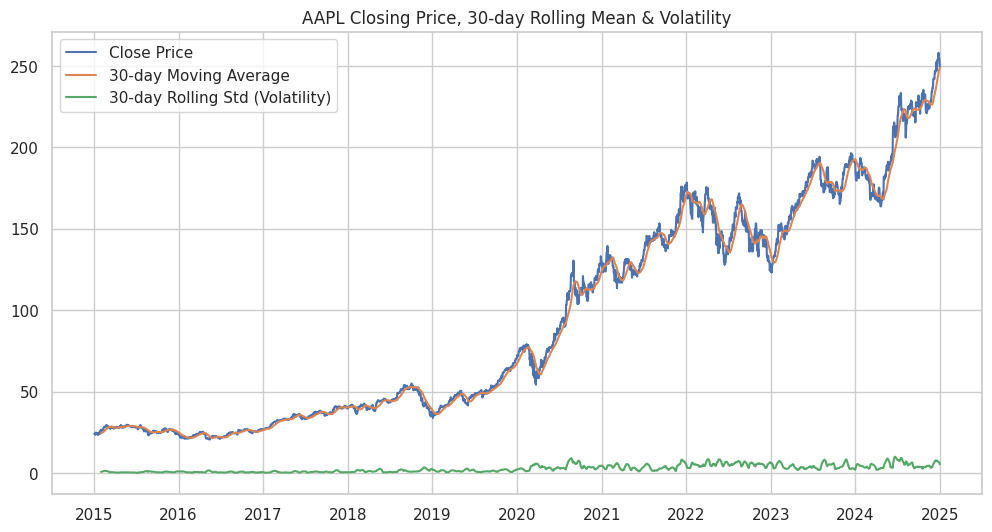

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Close'].rolling(window=30).mean(), label='30-day Moving Average')
plt.plot(data['Close'].rolling(window=30).std(), label='30-day Rolling Std (Volatility)')
plt.title("AAPL Closing Price, 30-day Rolling Mean & Volatility")
plt.legend()
plt.show()


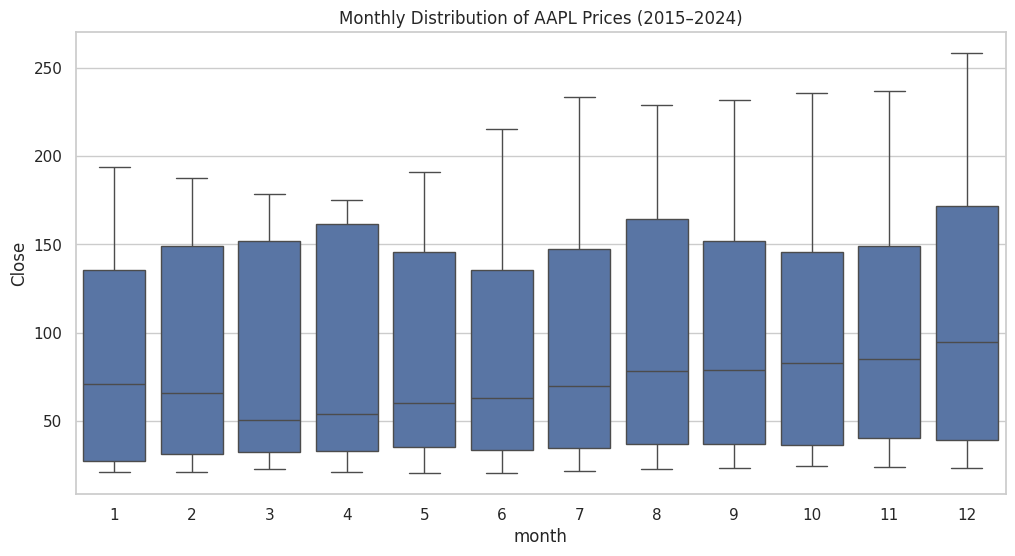

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='month', y='Close', data=data.reset_index())
plt.title("Monthly Distribution of AAPL Prices (2015–2024)")
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['Close'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])


ADF Statistic: 0.9059973054102997
p-value: 0.99316809577712


In [ ]:
train = data[:'2022']
test = data['2023':]
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (2921, 5)
Test shape: (731, 5)


In [ ]:
# Apply first difference
diff_series = train['Close'].diff().dropna()

# ADF test again
adf_result_diff = adfuller(diff_series)
print("ADF Statistic (1st diff):", adf_result_diff[0])
print("p-value:", adf_result_diff[1])


ADF Statistic (1st diff): -9.49271844383901
p-value: 3.616481057672347e-16


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model = ARIMA(train['Close'], order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2921
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5202.184
Date:                Wed, 01 Oct 2025   AIC                          10416.368
Time:                        04:10:23   BIC                          10452.244
Sample:                    01-02-2015   HQIC                         10429.290
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0648      0.010     -6.494      0.000      -0.084      -0.045
ar.L2         -0.0293      0.013     -2.287      0.022      -0.054      -0.004
ar.L3          0.0051      0.012      0.419      0.6

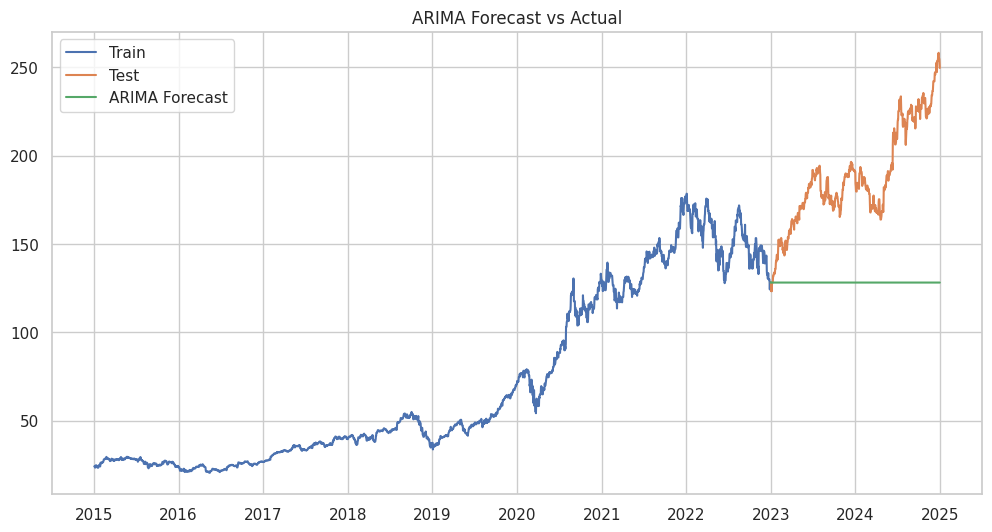

ARIMA RMSE: 66.49562986975484


In [ ]:
# Forecast same length as test
forecast = model_fit.forecast(steps=len(test))

# Compare with test data
plt.figure(figsize=(12,6))
plt.plot(train['Close'], label='Train')
plt.plot(test['Close'], label='Test')
plt.plot(test.index, forecast, label='ARIMA Forecast')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

# Calculate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test['Close'], forecast))
print("ARIMA RMSE:", rmse)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/d99d1he1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/bkt7__wn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40603', 'data', 'file=/tmp/tmp0ak7mwh_/d99d1he1.json', 'init=/tmp/tmp0ak7mwh_/bkt7__wn.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modeln5e7b9pi/prophet_model-20251001041028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:10:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


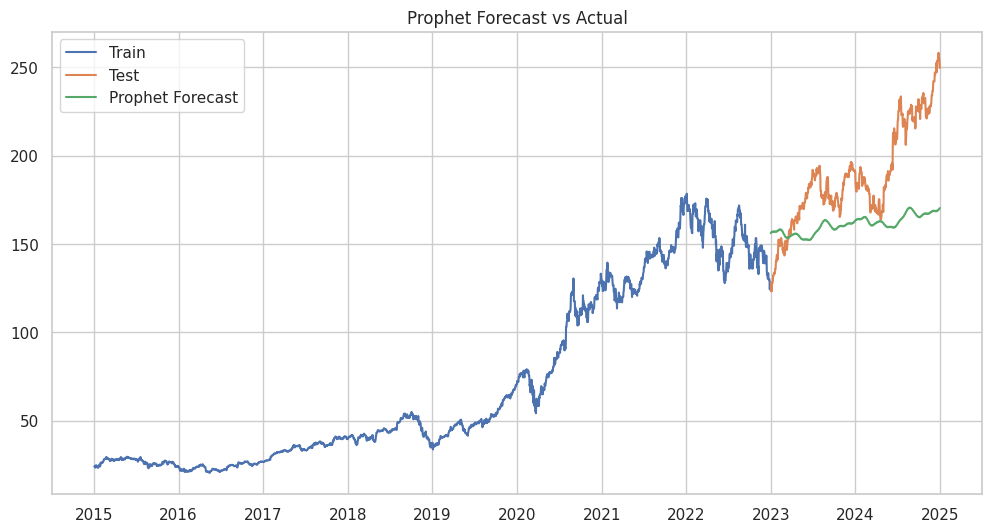

Prophet RMSE: 36.88935248322578


In [ ]:
from prophet import Prophet
import pandas as pd

# Prepare data for Prophet (rename columns)
prophet_df = train[['Close']].reset_index()
prophet_df.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_df)

# Forecast for test period
future = pd.DataFrame(test.index)
future.columns = ['ds']
forecast = prophet_model.predict(future)

# Plot forecast vs actual
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(train.index, train['Close'], label='Train')
plt.plot(test.index, test['Close'], label='Test')
plt.plot(forecast['ds'], forecast['yhat'], label='Prophet Forecast')
plt.title("Prophet Forecast vs Actual")
plt.legend()
plt.show()

# Evaluate RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_prophet = np.sqrt(mean_squared_error(test['Close'], forecast['yhat']))
print("Prophet RMSE:", rmse_prophet)


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' price
lstm_data = data[['Close']]

# Scale between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(lstm_data)

# Train-test split (same as before: until 2022 for training, 2023+ for test)
train_size = len(train)
train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size-60:]  # include overlap for sequences


In [ ]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

# Reshape for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (2861, 60, 1)
X_test shape: (731, 60, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Forecast next value

model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 0.0122 - val_loss: 7.7232e-04
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 7.6608e-04 - val_loss: 8.5026e-04
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 7.3144e-04 - val_loss: 0.0014
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 7.2239e-04 - val_loss: 6.8956e-04
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 6.6011e-04 - val_loss: 6.9065e-04
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.7623e-04 - val_loss: 8.0112e-04
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 5.9372e-04 - val_loss: 6.0734e-04
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 6.6139e-04 - val_loss: 0.0013
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 4.6470e-04 - val_loss: 8.6288e-04
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 5.2587e-04 - val_loss: 6.6170e-04
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 6.2804e-04 - val_loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
LSTM RMSE: 8.329512189564761


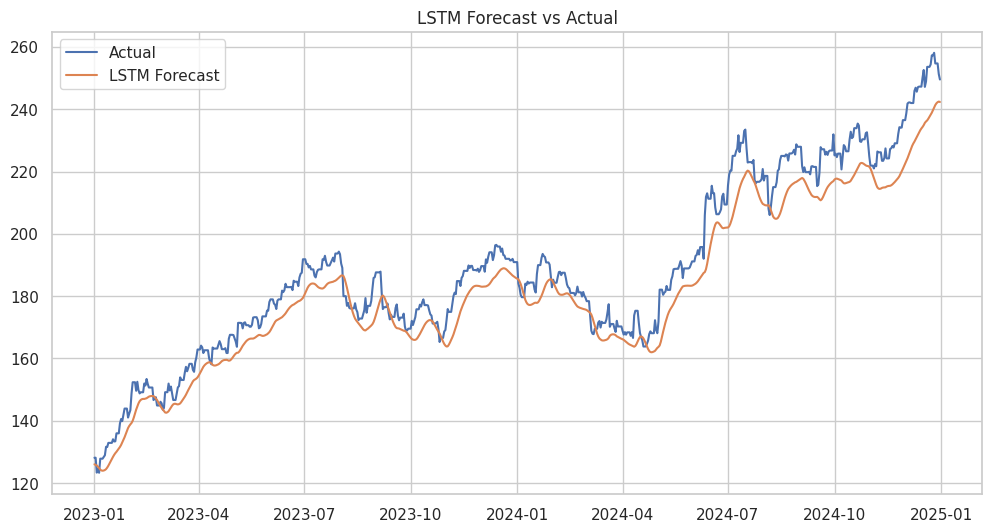

In [ ]:
# Predictions
y_pred = model.predict(X_test)

# Inverse scale back to original values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

# Evaluate RMSE
from sklearn.metrics import mean_squared_error
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print("LSTM RMSE:", rmse_lstm)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(test.index, y_test_rescaled, label='Actual')
plt.plot(test.index, y_pred_rescaled, label='LSTM Forecast')
plt.title("LSTM Forecast vs Actual")
plt.legend()
plt.show()


In [ ]:
# Suppose your trained model is called model_lstm
model.save('lstm_model_aapl.h5')  # Save as HDF5 file


In [ ]:
from google.colab import files
files.download('lstm_model_aapl.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

results = {
    "Model": ["ARIMA(5,1,0)", "Prophet", "LSTM"],
    "RMSE": [66.49, 36.93, float(rmse_lstm)]
}

results_df = pd.DataFrame(results)
print(results_df)


          Model       RMSE
0  ARIMA(5,1,0)  66.490000
1       Prophet  36.930000
2          LSTM   8.329512


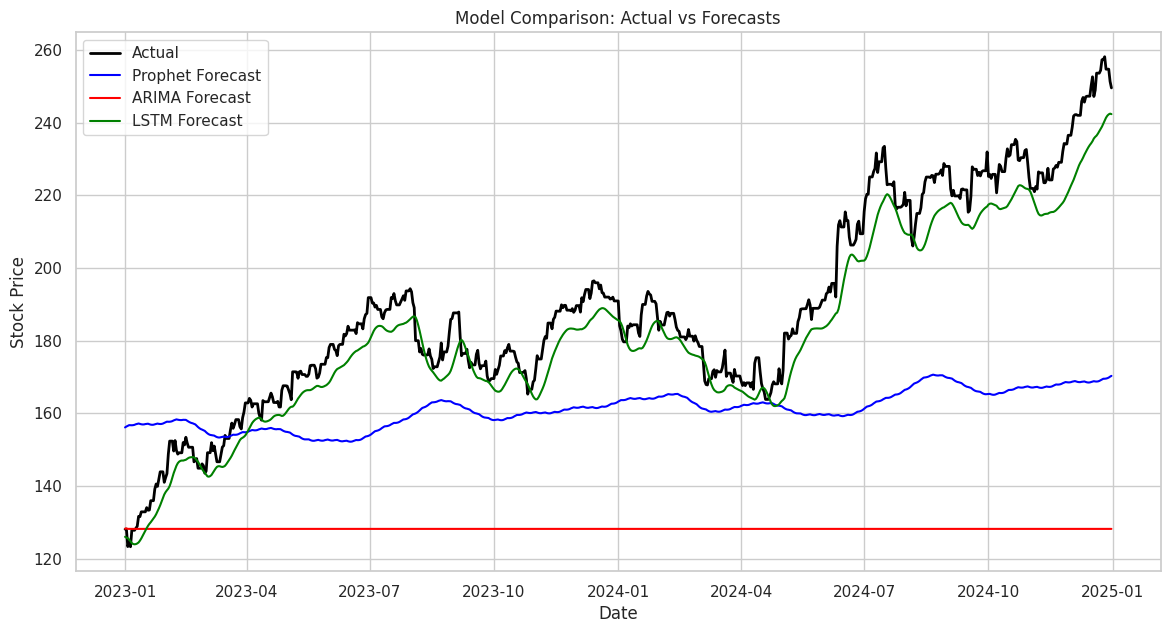

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(test.index, test['Close'], label='Actual', linewidth=2, color="black")

# Prophet forecast (only yhat)
plt.plot(test.index, forecast['yhat'].values, label='Prophet Forecast', color="blue")

# ARIMA forecast (from earlier ARIMA model)
arima_forecast = model_fit.forecast(steps=len(test))
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color="red")

# LSTM forecast (align to last len(y_test_rescaled) dates)
plt.plot(test.index[-len(y_pred_rescaled):], y_pred_rescaled, label='LSTM Forecast', color="green")

plt.title("Model Comparison: Actual vs Forecasts")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


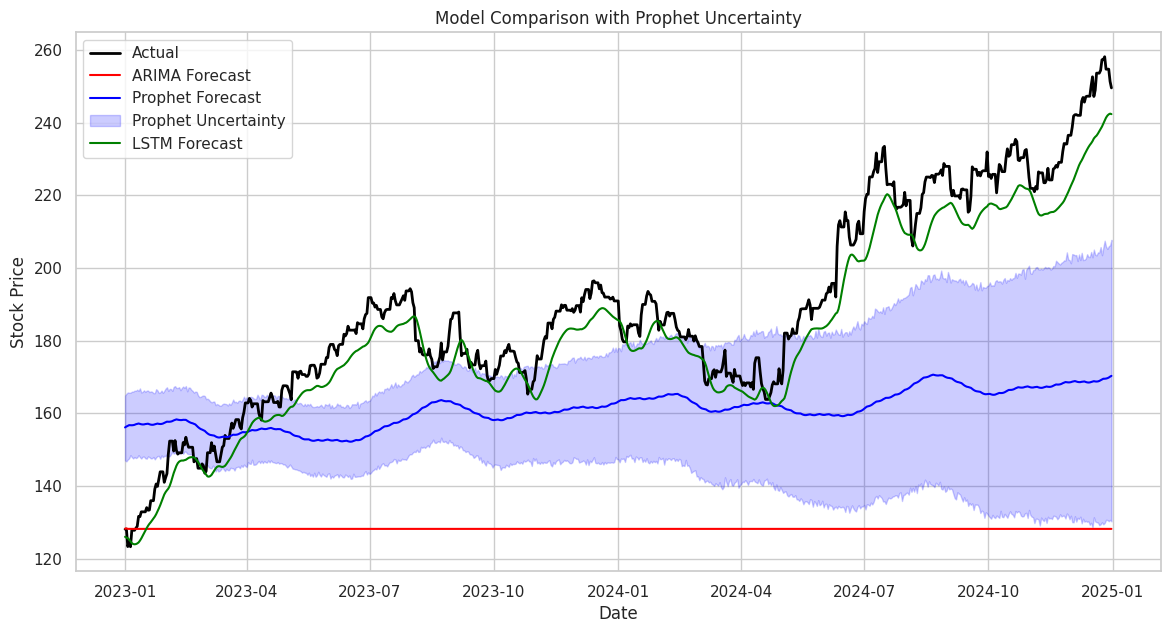

In [ ]:
plt.figure(figsize=(14,7))

# Actual
plt.plot(test.index, test['Close'], label='Actual', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')

# Prophet forecast
plt.plot(test.index, forecast['yhat'].values, label='Prophet Forecast', color='blue')

# Prophet uncertainty interval
plt.fill_between(test.index,
                 forecast['yhat_lower'].values,
                 forecast['yhat_upper'].values,
                 color='blue', alpha=0.2, label='Prophet Uncertainty')

# LSTM forecast
plt.plot(test.index[-len(y_pred_rescaled):], y_pred_rescaled, label='LSTM Forecast', color='green')

plt.title("Model Comparison with Prophet Uncertainty")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


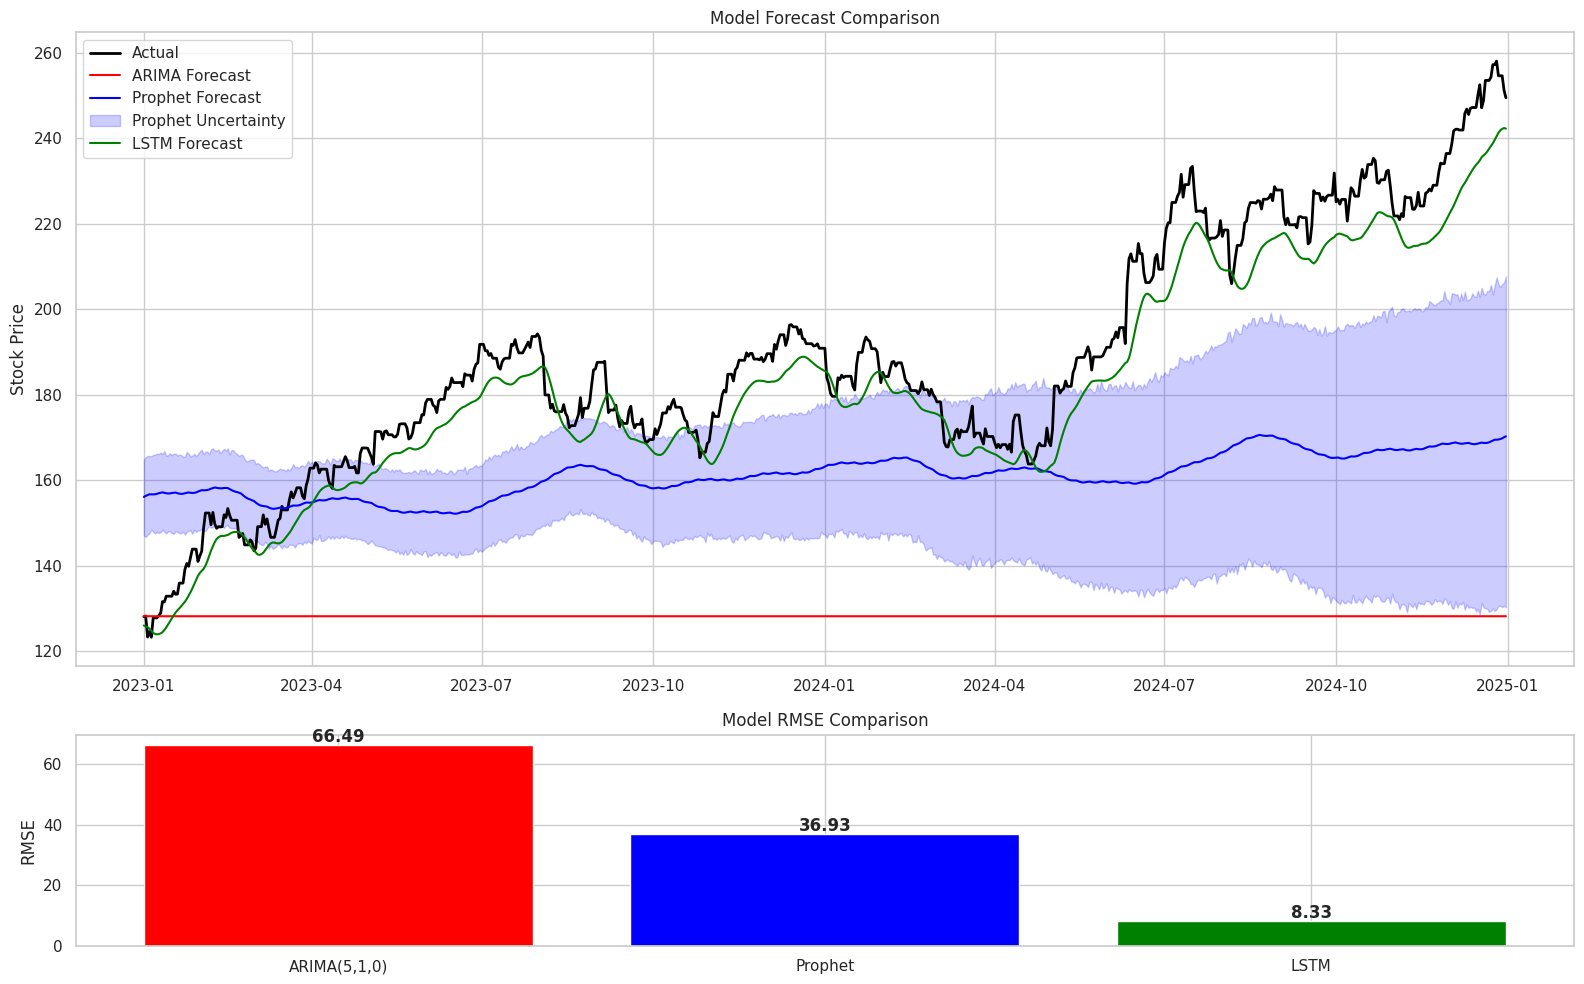

In [ ]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(16,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# Top plot: Forecast comparison
ax0 = plt.subplot(gs[0])
ax0.plot(test.index, test['Close'], label='Actual', color='black', linewidth=2)
ax0.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red')
ax0.plot(test.index, forecast['yhat'].values, label='Prophet Forecast', color='blue')
ax0.fill_between(test.index,
                 forecast['yhat_lower'].values,
                 forecast['yhat_upper'].values,
                 color='blue', alpha=0.2, label='Prophet Uncertainty')
ax0.plot(test.index[-len(y_pred_rescaled):], y_pred_rescaled, label='LSTM Forecast', color='green')
ax0.set_title("Model Forecast Comparison")
ax0.set_ylabel("Stock Price")
ax0.legend()

# Bottom plot: RMSE bar chart
ax1 = plt.subplot(gs[1])
ax1.bar(results_df['Model'], results_df['RMSE'], color=['red', 'blue', 'green'])
ax1.set_title("Model RMSE Comparison")
ax1.set_ylabel("RMSE")
for i, v in enumerate(results_df['RMSE']):
    ax1.text(i, v + 1, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.7 MB/s eta 0:00:00


In [ ]:
# Prophet tuning
from prophet import Prophet
import itertools
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# prepare prophet train/test dfs
prophet_train = train[['Close']].reset_index().rename(columns={'Date':'ds','Close':'y'})
prophet_test = test.reset_index().rename(columns={'Date':'ds','Close':'y'})

params_grid = {
    "changepoint_prior_scale": [0.001, 0.01, 0.1, 0.5],
    "seasonality_prior_scale": [0.1, 1.0, 10.0]
}

best_p = None
best_rmse = np.inf
for cps, sps in itertools.product(params_grid['changepoint_prior_scale'], params_grid['seasonality_prior_scale']):
    m = Prophet(daily_seasonality=False, yearly_seasonality=True,
                changepoint_prior_scale=cps, seasonality_prior_scale=sps)
    m.fit(prophet_train)
    future = prophet_test[['ds']]
    pred = m.predict(future)
    rmse = np.sqrt(mean_squared_error(prophet_test['y'], pred['yhat']))
    print(f"cps={cps}, sps={sps} -> RMSE={rmse:.4f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_p = (cps, sps)
print("BEST Prophet params:", best_p, "BEST RMSE:", round(best_rmse,4))
# Refit best model for later use:
best_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True,
                       changepoint_prior_scale=best_p[0], seasonality_prior_scale=best_p[1])
best_prophet.fit(prophet_train)
best_prophet_forecast = best_prophet.predict(prophet_test[['ds']])


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/ln_yde9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/tfbrqwc6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54978', 'data', 'file=/tmp/tmp0ak7mwh_/ln_yde9p.json', 'init=/tmp/tmp0ak7mwh_/tfbrqwc6.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelupa9ivlt/prophet_model-20251001041241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/538fd8xc.json


cps=0.001, sps=0.1 -> RMSE=20.7816


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/090l7wj7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6526', 'data', 'file=/tmp/tmp0ak7mwh_/538fd8xc.json', 'init=/tmp/tmp0ak7mwh_/090l7wj7.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_model_v4bwypt/prophet_model-20251001041242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/la1lw263.json


cps=0.001, sps=1.0 -> RMSE=20.6930


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/kfcfa5mb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89657', 'data', 'file=/tmp/tmp0ak7mwh_/la1lw263.json', 'init=/tmp/tmp0ak7mwh_/kfcfa5mb.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelazdg6ofj/prophet_model-20251001041243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/hltgj1_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/jc47dvwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.b

cps=0.001, sps=10.0 -> RMSE=21.2217


04:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/qyk4fj5n.json


cps=0.01, sps=0.1 -> RMSE=31.6226


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/b0fzy1rh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24950', 'data', 'file=/tmp/tmp0ak7mwh_/qyk4fj5n.json', 'init=/tmp/tmp0ak7mwh_/b0fzy1rh.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelw_78nkcv/prophet_model-20251001041246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/06n0ana4.json


cps=0.01, sps=1.0 -> RMSE=31.9768


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/bzd821lf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20657', 'data', 'file=/tmp/tmp0ak7mwh_/06n0ana4.json', 'init=/tmp/tmp0ak7mwh_/bzd821lf.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_model0b0euj4l/prophet_model-20251001041248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/6t_g4z3o.json


cps=0.01, sps=10.0 -> RMSE=32.0162


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/eib22ig0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49395', 'data', 'file=/tmp/tmp0ak7mwh_/6t_g4z3o.json', 'init=/tmp/tmp0ak7mwh_/eib22ig0.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelo0tw7w9s/prophet_model-20251001041251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/4_5ps6qw.json


cps=0.1, sps=0.1 -> RMSE=38.9210


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/_3bx3e8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6833', 'data', 'file=/tmp/tmp0ak7mwh_/4_5ps6qw.json', 'init=/tmp/tmp0ak7mwh_/_3bx3e8k.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_model8qt8r0mf/prophet_model-20251001041255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/nvlggfii.json


cps=0.1, sps=1.0 -> RMSE=38.6482


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/1vt0l452.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46706', 'data', 'file=/tmp/tmp0ak7mwh_/nvlggfii.json', 'init=/tmp/tmp0ak7mwh_/1vt0l452.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelhrefpjzt/prophet_model-20251001041259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:13:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/z5axahk3.json


cps=0.1, sps=10.0 -> RMSE=38.7764


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/esaw2bmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25653', 'data', 'file=/tmp/tmp0ak7mwh_/z5axahk3.json', 'init=/tmp/tmp0ak7mwh_/esaw2bmn.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelfplsmhrj/prophet_model-20251001041305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/rn2znlhi.json


cps=0.5, sps=0.1 -> RMSE=43.4989


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/5soj4d6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58224', 'data', 'file=/tmp/tmp0ak7mwh_/rn2znlhi.json', 'init=/tmp/tmp0ak7mwh_/5soj4d6e.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelaku9ty4v/prophet_model-20251001041311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/1vca61ur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/2p20i_8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.b

cps=0.5, sps=1.0 -> RMSE=43.3887


INFO:cmdstanpy:Chain [1] start processing
04:13:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/wxbppkpg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0ak7mwh_/o6wb9dwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11569', 'data', 'file=/tmp/tmp0ak7mwh_/wxbppkpg.json', 'init=/tmp/tmp0ak7mwh_/o6wb9dwb.json', 'output', 'file=/tmp/tmp0ak7mwh_/prophet_modelmvw3v0ep/prophet_model-20251001041315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:13:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


cps=0.5, sps=10.0 -> RMSE=43.5650
BEST Prophet params: (0.001, 1.0) BEST RMSE: 20.693


04:13:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Small ARIMA grid search (p,q from 0..3, d=1) - fast
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
warnings.filterwarnings("ignore")

best = {"order": None, "rmse": np.inf, "aic": np.inf}
for p in range(0,4):
    for q in range(0,4):
        try:
            model = ARIMA(train['Close'], order=(p,1,q)).fit()
            fc = model.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test['Close'], fc))
            if rmse < best['rmse']:
                best.update({"order": (p,1,q), "rmse": rmse, "aic": model.aic})
        except Exception:
            pass

print("Best ARIMA by RMSE:", best)
# Refit best ARIMA for later use
best_arima_model = ARIMA(train['Close'], order=best['order']).fit()
best_arima_forecast = best_arima_model.forecast(steps=len(test))


Best ARIMA by RMSE: {'order': (3, 1, 3), 'rmse': np.float64(63.81706317375489), 'aic': np.float64(10407.375837997355)}
